# Import libraries

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils import data

from sklearn.preprocessing import StandardScaler

from tqdm import tqdm_notebook

# %matplotlib inline
%matplotlib notebook

# Load data

In [26]:
# define path to dataset

# path to file in guanaco
# pathToFile = "/home/shared/astro/PLAsTiCC/"

# path to file in local 
pathToFile = "/home/leo/Desktop/plasticc_dataset/"

### <font color='red'>Things to do:</font>
- Use all the data (not just training)
- Using only a specific type of astronomical object (variable stars used in paper)

In [ ]:
# train path
# trainPath = "plasticc_train_lightcurves.csv"
# trainMetaPath = "plasticc_train_metadata.csv"

trainPath = "plasticc_test_set_batch1.csv"
trainMetaPath = "plasticc_test_metadata.csv"

# load in df
df1 = pd.read_csv(pathToFile + trainPath)
mdf1 = pd.read_csv(pathToFile + trainMetaPath)

# # load test df
# df2 = pd.read_csv(pathToFile + testPath)
# mdf2 = pd.read_csv(pathToFile + testMetaPath)

# display head
display(df1.head())
display(mdf1.head())

# print("testing df")

# display(df2.head())
# display(mdf2.head())
        
# merge dataframes
# merging data using object_id 
mdf1 = df1.merge(mdf1, on = "object_id")
# mdf2 = df2.merge(mdf2, on = "object_id")

# display merged data
print("final merged")
display(mdf1.head())
# display(mdf2.head())

# combine dataframes
# mdf1 = pd.concat([mdf1, mdf2])

In [ ]:
# printing dataframe shapes
print("Shape of data to work: ", mdf1.shape)
print("Unique targets: ", mdf1.true_target.unique().shape[0])
print("targets: ", mdf1.true_target.unique())

# Plotting one light curve
To check the data

In [ ]:
# get one light curve
oneLightCurve = mdf1[mdf1["object_id"] == 13]

# display plot
fig, ax = plt.subplots()
ax.scatter(oneLightCurve["mjd"], oneLightCurve["flux"])
ax.set_xlabel("MJD (date)")
ax.set_ylabel("Flux (bright)")
ax.set_title("Light curve for an specific object")

# Formating dataset to work
- Change name to dataframe (for simplicity)

- Select useful variables

### <font color='red'>Things to do:</font>
- Are we going to work only with "flux"? (Maybe flux error)

In [ ]:
# change name to dataframe
lightCurves = mdf1

# for take only a part of classes and remove anothers ones
# lightCurves = lightCurves.loc[lightCurves["true_target"].isin(classesToAnalyze)]

# filter by passband
# for simplicity selecting one passband
lightCurves = lightCurves[lightCurves.passband == 1]


# getting only useful features
lightCurves = lightCurves[["object_id", "mjd", "flux", "flux_err", "true_target"]]
lightCurves = lightCurves.rename(columns={"true_target": "target"})
# display(lightCurves.head())


# printing information
display(lightCurves.head())
print("data shape: ", lightCurves.shape)
print("original objects ids: ", lightCurves.object_id.unique().shape)
# print("original classes: ", lightCurves.true_target.unique().shape)
print("original classes: ", lightCurves.target.unique().shape)

(7732, 5)


<IPython.core.display.Javascript object>


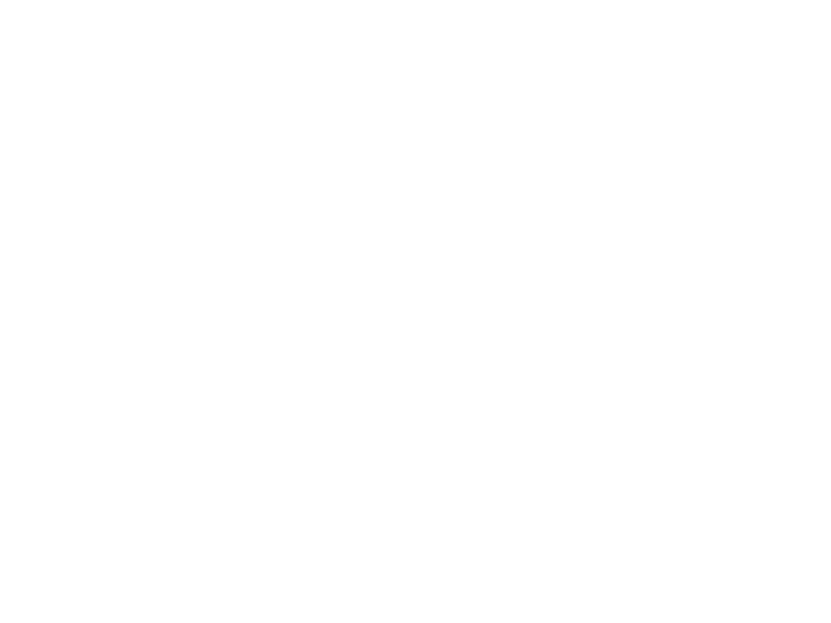

(array([ 170.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        7562.]),
 array([16. , 23.6, 31.2, 38.8, 46.4, 54. , 61.6, 69.2, 76.8, 84.4, 92. ]),
 <a list of 10 Patch objects>)

In [7]:
# selecting classes
lightCurves = lightCurves[lightCurves["target"].isin([92, 16, 63])]

print(lightCurves.shape)

plt.figure()
plt.hist(lightCurves.target)

# Standarizing data

### <font color='red'>Things to do:</font>
- Is the StandarScaler correct?

In [8]:
# standarizing variables
# this returns a numpy array
stdLightCurves = StandardScaler().fit_transform(lightCurves.loc[:, ["flux", "flux_err"]])
display(stdLightCurves.shape)

# create new array wth standarized data
lightCurvesStd = lightCurves
# overwrite data
lightCurvesStd["flux"] = stdLightCurves[:, 0]
lightCurvesStd["flux_err"] = stdLightCurves[:, 1]

#printing dataset
display(lightCurvesStd.head())

(7732, 2)

,object_id,mjd,flux,flux_err,target
6442,168,59750.4306,-0.002915,-0.870961,16
6446,168,59752.4147,-0.016291,-0.919817,16
6451,168,59767.3045,-0.003746,-0.930697,16
6456,168,59770.2256,-0.003185,-0.835170,16
6461,168,59779.3265,-0.001811,-0.832850,16


# Feature extraction with Variatonal Autoencoder 

# Formating data to train VAE

# Defining data to use

### <font color='red'>Things to do:</font>
- We have to use the "paper" data forma (detla time and delta flux)?

In [9]:
# Create dataset
# selecting columns to use
variableIndexStart = 2
variableIndexEnd = -2

# define data to use
dataToUse = lightCurvesStd.iloc[:, variableIndexStart:variableIndexEnd].values

# display data shape
display(dataToUse.shape)

(7732, 1)

# Transform dataset to light curves dataset 
Because all the light curves have different lenghts, I am going to take a specific number of sample for each light curve

### <font color='red'>Things to do:</font>
- Is it correct to "truncate" the light curve to a fixed length?
- If we work with variable starts, maybe we can apply margin technique (paper) to fill the missed data

In [10]:
#  check the different lenghts of all light curves
lightCurvesLenght = np.zeros(shape = (lightCurvesStd.object_id.unique().shape[0],))

# transform ethe data set into array: [light curve,]
for i, objectId in enumerate(lightCurvesStd.object_id.unique()):
    
#     print(objectId)
    lightCurvesLenght[i] = lightCurvesStd[lightCurvesStd.object_id == objectId].shape[0]

<IPython.core.display.Javascript object>


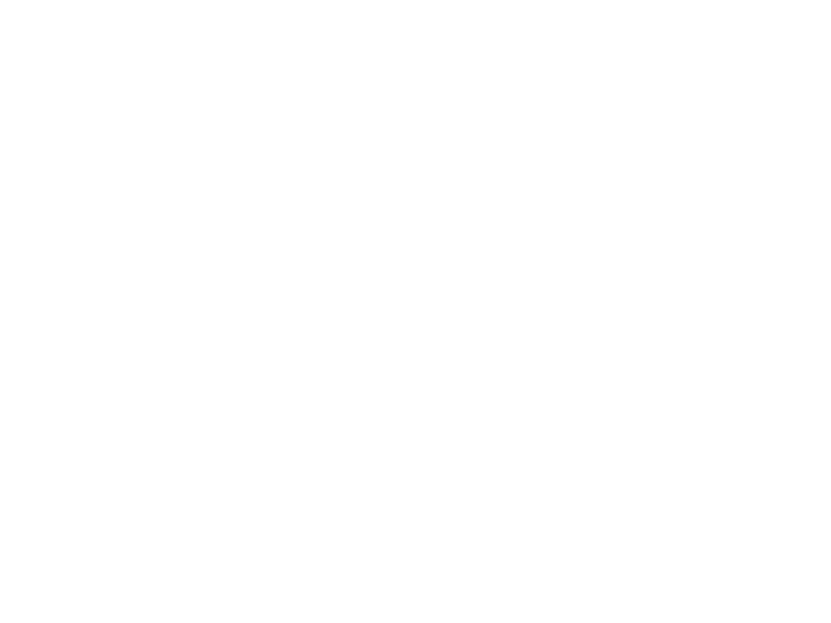

In [11]:
plt.figure()
plt.hist(lightCurvesLenght, bins = 30)
plt.show()

In [12]:
# I am going to select a fixed lenght for each light curve of specific points for each light curve

# selecting the fixed lenght for each light curve
count = 0
lengthToSelect = 50

for i, objectId in enumerate(lightCurvesStd.object_id.unique()):
    if lightCurvesStd[lightCurvesStd.object_id == objectId].shape[0] > lengthToSelect:
        count += 1
print(count)

107


In [13]:
# checking df es working correctly
lightCurvesStd.head()

,object_id,mjd,flux,flux_err,target
6442,168,59750.4306,-0.002915,-0.870961,16
6446,168,59752.4147,-0.016291,-0.919817,16
6451,168,59767.3045,-0.003746,-0.930697,16
6456,168,59770.2256,-0.003185,-0.835170,16
6461,168,59779.3265,-0.001811,-0.832850,16


In [14]:
# build dataset with new fixed lenght of each llight curve
lightCurvesById = np.zeros(shape = (count, lengthToSelect))
i_ = 0

for i, objectId in enumerate(lightCurvesStd.object_id.unique()):
    
    if lightCurvesStd[lightCurvesStd.object_id == objectId].shape[0] > lengthToSelect:
        
        lightCurvesById[i_, :] = lightCurvesStd[lightCurvesStd.object_id == objectId]["flux"][0:lengthToSelect]
        
        i_ += 1
        
lightCurvesById.shape

(107, 50)

Now the dataset is an array where each row is a time serie of fixed length

<IPython.core.display.Javascript object>


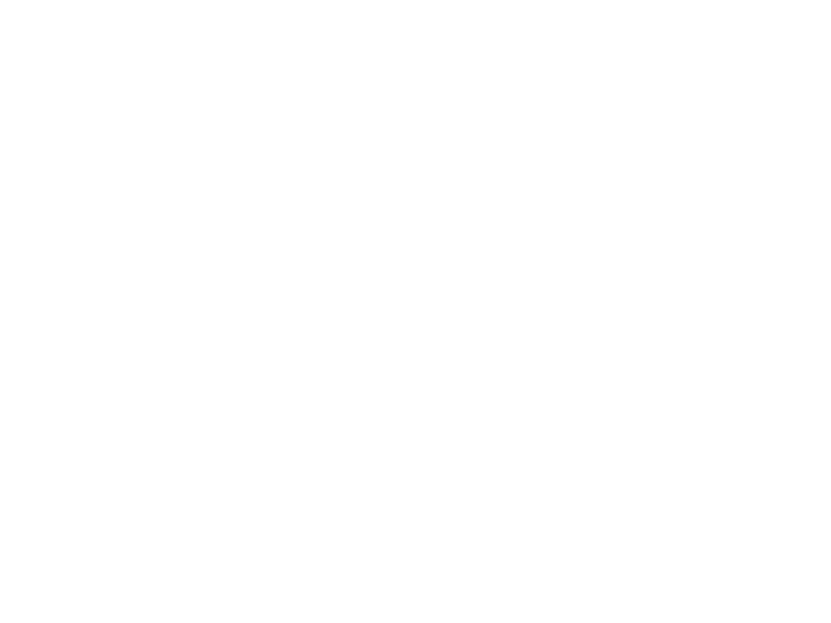

In [15]:
# check visualizelly the correctnes of array
# display(lightCurvesById)
plt.figure()
plt.plot(lightCurvesById[10])
plt.show()

# Data to tensor

In [16]:
# variables
torchData = torch.from_numpy(lightCurvesById).float()

# torchData.shape

# targets
# target is the same as 
# torchTargets = torch.tensor(lightCurvesStd.iloc[:, -1].values).float()

# creating dataset
dataset = data.TensorDataset(torchData)

# Spliting data (train/test)

In [17]:
# Spliting the data

# selecting train splitting
train_size = int(0.8 * lightCurvesById.shape[0])

# getting test splitting
test_size = lightCurvesById.shape[0] - train_size

# spliting the torch dataset
trainDataset, testDataset = torch.utils.data.random_split(dataset, [train_size, test_size])


# Create data loader (minibatches)

# train loader
trainLoader = data.DataLoader(trainDataset, batch_size=256)

# test loader
testLoader = data.DataLoader(testDataset)

## Define autoencoder structure
To start with the work, It is going to build a very basic Autoencoder

### <font color='red'>Things to do:</font>
- Is it correct the structure? Because the distribution function is in the reparametize function (assuming it is normal distribution)

In [18]:
# Buiding autoencoder

# Assuming this has a normal distrubtion in the latent part

# encoder
class Encoder(torch.nn.Module):
    
    # init method
    def __init__(self, latent_dim, hidden_dim, input_dim):

        super(Encoder, self).__init__()
        
        # 1 Convolution layer
        # Conv1d(input channel, output channel, kernel size)
        self.conv1 = torch.nn.Conv1d(1,64,3)
        
        # this is to consider time and magnitude
#         self.conv1timepo = torch.nn.Conv1d(1, 64, 3)
#         self.conv1mag = torch.nn.Conv1d(1, 64, 3)
        
        # 2 Convolution layer
        # Conv1d(input channel, output channel, kernel size)
        self.conv2 = torch.nn.Conv1d(64, 32, 3)
        
        # linear layer
        self.hidden1 = torch.nn.Linear(1472, hidden_dim)
        
        # mu
        self.mu = torch.nn.Linear(hidden_dim, latent_dim)
        
        # sigma
        self.logVar = torch.nn.Linear(hidden_dim, latent_dim)
        
        # activation function
        self.activationConv = torch.nn.ReLU() #max(0, x)
    
        self.activationLinear = torch.nn.Tanh()

    # forward method
    def forward(self, x):
            
#         print("input shape: {0}".format(x.shape))
        
         # Input shape to conv:
        # [batch_size, channels, sequence_length]
        # reshapa data (add number of channels)
        # shape should be: [batch_size, 1 channel, lenght of light curve (50)]
        x = x.unsqueeze(1)
        
#         print("input reshape: {0}".format(x.shape))
        
        # convolution 1
        # x -> conv -> act -> ouput
        # shape should be: [batch_size, number of ouput channels (64), length of output from convolution]
        output = self.activationConv(self.conv1(x))
        
#         print("output conv1 shape: {0}".format(output.shape))
        
        # convolution 2
        # shape should be: [batch_size, number of ouput channels (32), length of output from convolution]
        output = self.activationConv(self.conv2(output))
#         print("output conv2 shape: {0}".format(output.shape))
        
        # flatten ouput
        # shape should be: [batch_size, -1]
        output = output.view(output.shape[0], -1)
        
#         print("output reshape: ", output.shape)
        
        # x -> hidden1 -> activation
        output = self.activationLinear(self.hidden1(output))
#         print("hidden1 output shape: {0}".format(output.shape))
        
#         output = self.activation(self.hidden2(output))
        
        # get mu
        # sin tangenteh!!!
        mu = self.mu(output)
#         print("mu shape: {0}".format(mu.shape))
        
        # get sigma
        # parametrizar logaritmo de sigma (y después  en el sampligng se obtiene exponencial)
        logVar = self.logVar(output)
        #         print("sigma shape: {0}".format(sigma.shape))
        
        # returning values
        return mu, logVar

    
# decoder    
class Decoder(torch.nn.Module):
    
    # define layers
    def __init__(self, latent_dim, hidden_dim, output_dim):
        
        super(Decoder, self).__init__()
        
        # linear layer
        self.hidden1 = torch.nn.Linear(latent_dim, 1472)
        
        # 1 ConvolutionTrans layer
        self.convTrans1 = torch.nn.ConvTranspose1d(32, 64, 3)
        
        # 2 ConvolutionTrans layer
        self.convTrans2 = torch.nn.ConvTranspose1d(64, 1, 3)

        # activation function
        self.activationConv = torch.nn.ReLU() #max(0, x)
    
        self.activationLinear = torch.nn.Tanh()
        
    # forward method
    def forward(self, z):
        
#         print("input dimension decoder: {0}".format(z.shape))
        
        # linear (from latent to hidden dimension)
        # z -> linaer layer -> activation -> output
        output = self.activationLinear(self.hidden1(z))
#         print("output hidden1: {0}".format(output.shape))
        
        # reshape (I don't know if it is correct)
        # output = output.view(output.shape[0], 1, -1)
        output = output.view(output.shape[0], 32, -1)
#         print("output reshape: {0}".format(output.shape))
        
        # 1 convolution
        output = self.activationConv(self.convTrans1(output))
#         print("ouput convTrans1: {0}".format(output.shape))
        
        # 2 convolution
#         output = self.activationConv(self.convTrans2(output))
        output = self.convTrans2(output)
#         print("ouput convTrans2: {0}".format(output.shape))
        
        # remove one dimensionl (channel)
        output = output.view(output.shape[0], -1)
#         print("remove channel: {0}".format(output.shape))
        
        # Maybe add activation function?
#         return (self.decode(output))
        return output

# building the autoencoder     
class AutoEncoder(torch.nn.Module):
    
    # defining the initial structure
    def __init__(self, latent_dim, hidden_dim, input_dim = lightCurvesById.shape[1]):
        
        super(AutoEncoder, self).__init__()
        
        # defining the encoder
        self.encoder = Encoder(latent_dim, hidden_dim, input_dim)
        
        # defining the decoder
        # note the output dimension in the decoder is the same as input dimension
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    # distribution function
    def sampling(self, mu, logvar, k = 1):
        
        # assumming normal distribution
#         s = torch.exp(0.5*sigma)
#         eps = torch.rand_like(s) # generate a iid standard normal same shape as s
#         return eps.mul(s).add_(mu)
        batch_size, n_latent = logvar.shape
        std = (0.5*logvar).exp()
#         eps = torch.randn(batch_size, k, n_latent, device=std.device, requires_grad=False)
        eps = torch.randn(batch_size, k, n_latent, requires_grad=False)
        return eps.mul(std.unsqueeze(1)).add(mu.unsqueeze(1))
    
    # forward method (how to the nn works)
    def forward(self, x):
        
#         print("input size: {0}".format(x.shape))
        
#         print("## Encoder ##")
        # input (x) -> encoder -> latent variables
        mu, logVar = self.encoder(x)
#         print("output encoder size: {0}".format(mu.shape))
    
        # getting sample
        # mu, sigma -> distribution -> z
        z = self.sampling(mu, logVar)
#         print("z shape: ", z.shape)
        
#         print("## Dencoder ##")
        # latent variables -> decoder -> reconstruction (x)
#         decOutput = self.decoder(encOutput)
        decOutput = self.decoder(z)
#         print("output decoder size: {0}".format(decOutput.shape))
        
        return decOutput

## Defining parameters to Autoencoder

In [19]:
# check number of parameters
latentDim = 7
hiddenDim = 5

# defining model
model = AutoEncoder(latent_dim = latentDim, hidden_dim = hiddenDim)

In [20]:
print("input dimension: {0}".format(lightCurvesById.shape))

# parameters number
count = 0

# # check model dimension
for name, param in model.state_dict().items():
    # name: str
    # param: Tensor
#     print("{0}: {1} \n".format(name, param.shape))
#     print(param.shape[0]*(param.shape[1] if len(param.shape)>1 else 1))
#     print(param.shape)
    count += param.shape[0]*(param.shape[1] if len(param.shape)>1 else 1)
# for param in model.parameters():
    
print("number of parameters: " + str(count))

input dimension: (107, 50)
number of parameters: 23610


### <font color='red'>Things to do:</font>
- Is it correct this loss function? Or just use: "criterion = torch.nn.MSELoss(reduction = "sum") "

In [21]:
from torch.nn import functional as F

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    
#     print("reconstruction: {0}".format(recon_x))
#     print("x: {0}".format(x))
#     print("mu: {0}".format(mu))
#     print("logvar: {0}".format(logvar))
    
#     BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    BCE = F.mse_loss(recon_x, x, reduction='sum')
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
#     print(BCE)
    
    return BCE + KLD

<IPython.core.display.Javascript object>


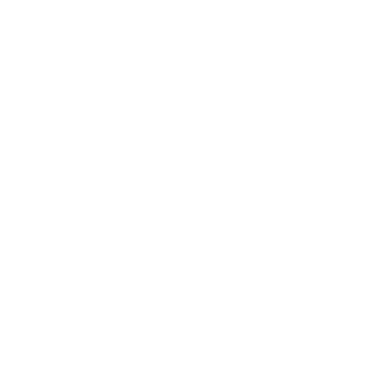

/home/leo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  2
early stopping counter:  1
early stopping counter:  1
early stopping counter:  2
early stopping counter:  1
early stopping counter:  2
early stopping counter:  3
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  2
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  2
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  1
early stopping counter:  2
e

KeyboardInterrupt: 

In [22]:
# loss function
criterion = torch.nn.MSELoss(reduction = "sum")

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

# use of GPU flag
use_gpu = False

# load model on GPU
if use_gpu:
    model = model.cuda()

# number of epochs
epochs = 1000000

# loss
train_loss = np.zeros((epochs,))
test_loss = np.zeros((epochs,))

# loss plot
fig, ax = plt.subplots(figsize = (3, 3), tight_layout = True)
# fig, ax = plt.subplots()
ax.set_xlabel("Epoch")
ax.set_ylabel("Error")

# plt.legend()

# plt.axis([0,1000,0,10])
# plt.show()

# early stopping
prior_test_error = 0
count_early_stop = 0
threshold_early_stop = 100

for nepoch in tqdm_notebook(range(epochs)):
    
#     print("epoch: {0}".format(nepoch))
    
    # train
    epoch_train_loss = 0
    
    for data in trainLoader:
        
        data = data[0]
        
        optimizer.zero_grad()
        
        if use_gpu:
            
            data = data.type(torch.FloatTensor).cuda()
            outputs = model.forward(data.type(torch.FloatTensor).cuda())
            mu, logvar = model.encoder.forward(data.type(torch.FloatTensor).cuda())
            
        else:
                        
            data = data.type(torch.FloatTensor)
            outputs = model.forward(data.type(torch.FloatTensor))
            mu, logvar = model.encoder.forward(data.type(torch.FloatTensor))
        
#         loss = criterion(outputs, data)
        # use KLD + MSE
        loss = loss_function(outputs, data, mu, logvar)
#         print(loss)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    
    train_loss[nepoch] = epoch_train_loss
    
#     print(train_loss)
    
    # test
    epoch_test_loss = 0
    
    for data in testLoader:
        
        data = data[0]
        
        if use_gpu:
            
            data = data.type(torch.FloatTensor).cuda()
            outputs = model.forward(data.cuda())
            mu, logvar = model.encoder.forward(data.type(torch.FloatTensor).cuda())
        else:
            data = data.type(torch.FloatTensor)
            
            outputs = model.forward(data)
            
            mu, logvar = model.encoder.forward(data.type(torch.FloatTensor))
        
#         loss = criterion(outputs, data)
        loss = loss_function(outputs, data, mu, logvar)
        
        epoch_test_loss += loss.item()
    
    test_loss[nepoch] = epoch_test_loss
    
    # plot loss
    ax.plot(train_loss[0: nepoch], label = "train", linewidth = 3, c = "red") 
    ax.plot(test_loss[0: nepoch], label = "test", linestyle = "--", linewidth = 3, c = "green") 
    
    fig.canvas.draw()
#     plt.pause(0.000005)
    
        # Early stopping
    if epoch_test_loss > prior_test_error:
        count_early_stop += 1
        print("early stopping counter: ", count_early_stop)
    else: 
        count_early_stop = 0
    
    # update prior test error
    prior_test_error = epoch_test_loss
    
    # analyze early stopping
    if count_early_stop > threshold_early_stop:
        
        print("Early stopping in epoch: ", nepoch)
        break


<IPython.core.display.Javascript object>


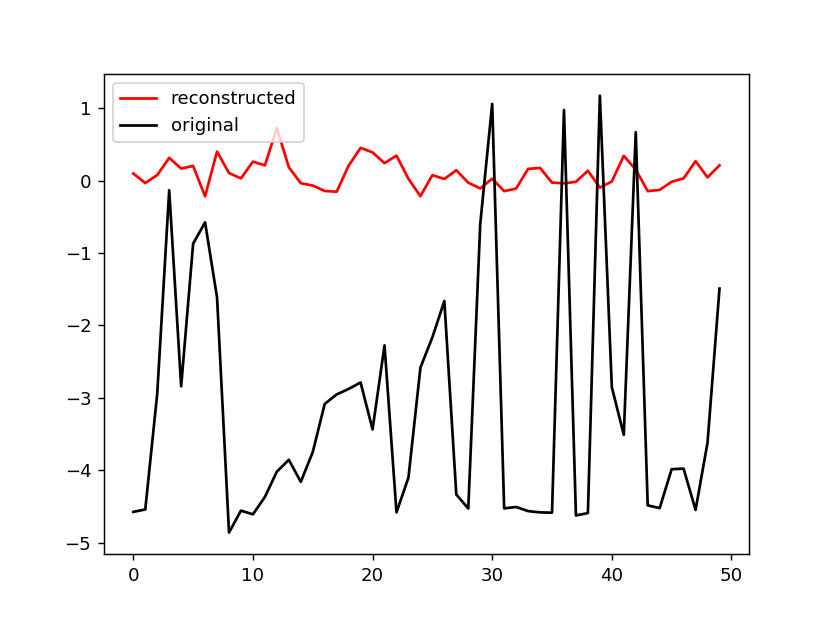

In [24]:
# reconstruction
reconstructedLightCurve = model.forward(list(testLoader)[0][0])
# display(reconstructedLightCurve.detach().numpy()[0])
fig, ax = plt.subplots()
ax.plot(reconstructedLightCurve.detach().numpy()[0], label = "reconstructed", color = "red")
ax.plot(data.detach().numpy()[0], label = "original", color = "black")
plt.legend()

### <font color='red'>Things to do:</font>
- Define metrics for evaluate models